In [2170]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2171]:
def date_parser(_date):
    return pd.to_datetime(_date).date

def my_plot(df, column=None):
    # prices = df[(df['postcode'] == 2607) & (df['propertyType'] == 'house')]['price']
    if column is None:
        prices = df['price']
    else:
        prices = df[column]
    plt.figure(figsize=(15,5))
    plt.xticks(rotation=45)
    plt.xticks(range(0, len(prices), 2))
    plt.plot(prices)

In [2172]:
df = pd.read_csv('data\\raw_sales.csv', index_col='datesold', date_parser=date_parser)

In [2173]:
###### property type replace with numeric
propertyType = {'house': 1,
                'unit': 2}
# df.replace(propertyType, inplace=True)
df['date'] = [f'{y}-0{m}' if m < 10 else f'{y}-{m}' for y,m in list(zip(df.index.year, df.index.month))]
## choosing bedrooms
df.drop(columns=['postcode'], inplace=True)
#### groupby month
df_groupped = df.groupby(by=['date', 'propertyType', 'bedrooms']).mean()
df_groupped = df_groupped.reset_index(drop=False)
df_groupped.set_index('date', inplace=True)
df_train = df_groupped.head(1000)
df_test = df_groupped.tail(df_groupped.shape[0] - 1000)
# apply normalization

def normalize_data(df, columns=[]):
    if columns == 'all':
        columns = df.columns
    for c in columns:
        df[c]=(df[c]-df[c].mean())/df[c].std()
    return df


df_train = normalize_data(df_train, columns=['price'])
df_test = normalize_data(df_test, columns=['price'])
df_groupped

,propertyType,bedrooms,price
date,,,
2007-02,house,3,290000.000000
2007-02,house,4,525000.000000
2007-03,house,3,319000.000000
2007-03,house,4,380000.000000
2007-04,house,3,399000.000000
...,...,...,...
2019-07,house,5,889538.461538
2019-07,unit,0,199000.000000
2019-07,unit,1,331261.904762


,propertyType,bedrooms,price
date,,,
2007-02,house,3,290000.000000
2007-02,house,4,525000.000000
2007-03,house,3,319000.000000
2007-03,house,4,380000.000000
2007-04,house,3,399000.000000
...,...,...,...
2019-07,house,5,889538.461538
2019-07,unit,0,199000.000000
2019-07,unit,1,331261.904762


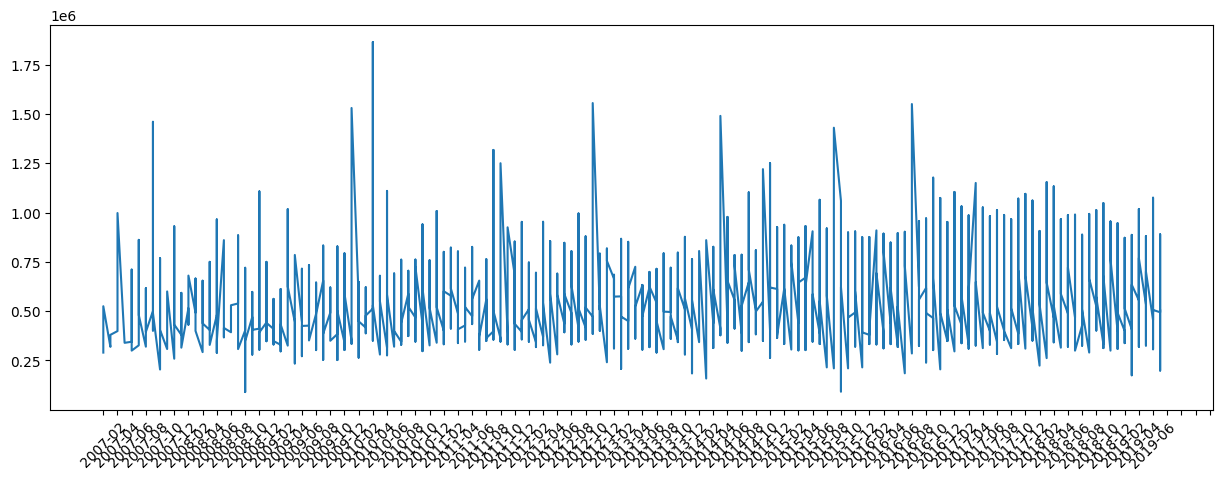

In [2174]:
my_plot(df_groupped)
df_groupped


In [2175]:
# differencing to remove trend
def diff_data(df, diff_step):
    df.sort_values(by='date', ascending=True, inplace=True)
    df['price'] = df.groupby(by=['propertyType'])['price'].diff(diff_step)
    df.dropna(how='any', axis=0, inplace=True)
    return df
    

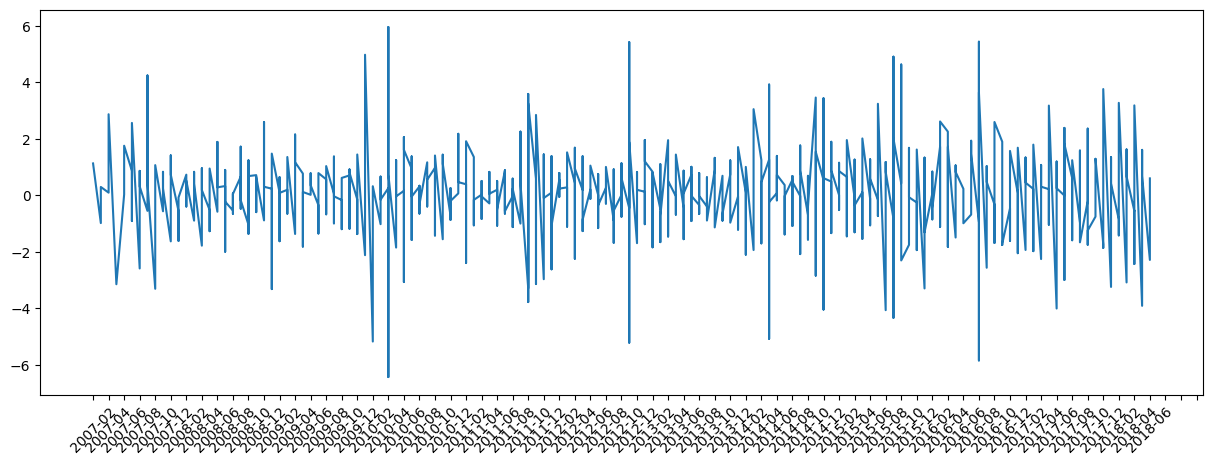

In [2176]:
df_train = diff_data(df_train, 1)
df_test = diff_data(df_test, 1)
my_plot(df_train)


In [2177]:
## removing seasonality
def remove_seasonality(df):
    df_month_mean = df.groupby(by=[pd.to_datetime(df.index).month, 'propertyType']).mean()
    df_month_mean.reset_index(drop=False, inplace=True)
    df_month_mean.rename(columns={'price':'price_mean',
                                  'date': 'month'}, inplace=True)
    df['month'] = df.index.str[-2:].astype(int)
    df['price_month_mean'] = df.index.map(lambda x: df_month_mean.loc[int(x.split('-')[1]), 'price_mean'])
    # df_groupped = pd.merge(df_groupped, df_month_mean, on=['month', 'postcode', 'propertyType', 'bedrooms'], how='inner')
    df['price'] = df['price'] - df['price_month_mean']
    return df



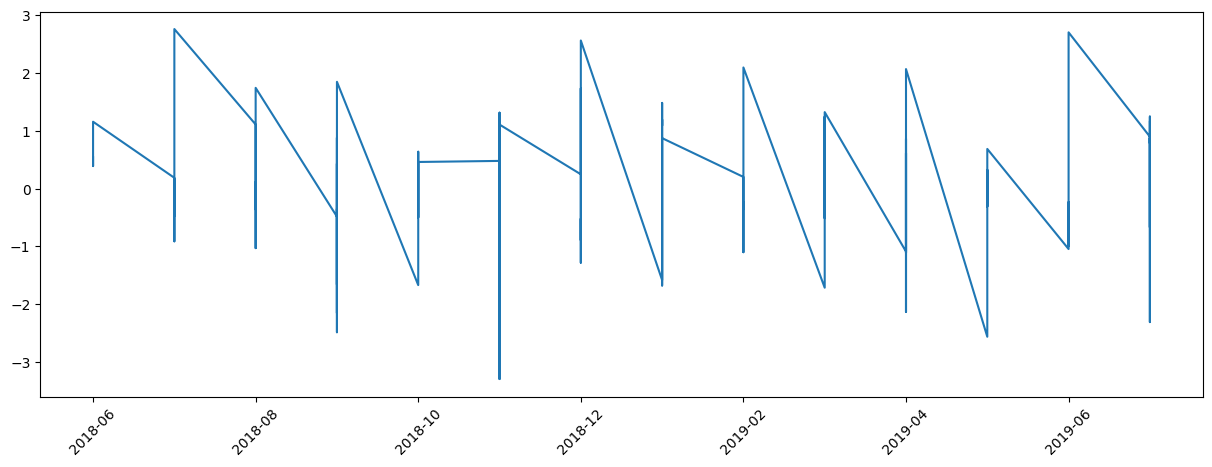

In [2178]:
df_train = remove_seasonality(df_train)
df_test = remove_seasonality(df_test)
my_plot(df_test)

In [2179]:
df_train.drop(['price_month_mean',
               'month'], axis=1, inplace=True)
df_test.drop(['price_month_mean',
               'month'], axis=1, inplace=True)
# df_train = normalize_data(df_train, columns=['propertyType', 'bedrooms', 'postcode'])
df_train.index = pd.to_datetime(df_train.index).date
df_test.index = pd.to_datetime(df_test.index).date
# df_test = normalize_data(df_test, columns=['propertyType', 'bedrooms', 'postcode'])
df_test

,propertyType,bedrooms,price
2018-06-01,house,5,0.540618
2018-06-01,unit,2,0.388978
2018-06-01,unit,3,1.155462
2018-07-01,unit,3,0.185827
2018-07-01,unit,2,-0.911646
...,...,...,...
2019-07-01,house,4,0.783186
2019-07-01,house,5,1.244685
2019-07-01,unit,0,-0.668832
2019-07-01,unit,1,0.969846


In [2180]:
df_train = df_train.pivot(columns=['propertyType', 'bedrooms'], values='price')
# df_train.T.reset_index(drop=False, inplace=True)
df_train = df_train.T.reset_index()
df_train['index'] = df_train.index.map(lambda x: (str(df_train.loc[x, 'propertyType']) + '_' + str(df_train.loc[x, 'bedrooms'])) )
df_train.set_index('index', inplace=True)
df_train.drop(columns=['propertyType', 'bedrooms'], inplace=True)
df_train = df_train.T
df_train.index = pd.to_datetime(df_train.index)
df_train.dropna(axis=1, how='all', inplace=True)
# df_train.dropna(axis=0, how='all', inplace=True)
df_train = df_train.fillna(df_train.mean())

df_train.drop(columns=['unit_5', 'house_0'], inplace=True)

df_train

index,house_4,house_3,unit_3,unit_2,house_5,house_1,house_2,unit_1,unit_0,unit_4
2007-02-01,1.077919,-0.415985,0.362013,-0.091549,0.915737,-1.184482,-0.445622,-0.530188,-0.267734,0.683409
2007-03-01,0.381052,-0.897535,0.362013,-0.091549,0.915737,-1.184482,-0.445622,-0.530188,-0.267734,0.683409
2007-04-01,2.858735,0.083674,0.362013,-0.091549,0.915737,-1.184482,-0.445622,-0.530188,-0.267734,0.683409
2007-05-01,0.339627,-3.036059,0.362013,-0.091549,0.915737,-1.184482,-0.445622,-0.530188,-0.267734,0.683409
2007-06-01,1.643017,-0.081719,0.362013,-0.091549,0.915737,-1.184482,-0.445622,-0.530188,-0.267734,0.683409
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,-0.907777,-1.263674,1.264045,-0.806577,3.221895,-1.468780,-0.556614,-0.906233,-0.267734,0.356874
2018-03-01,1.173822,0.231073,0.345096,0.536353,1.512818,-2.998413,1.708484,-0.751479,-0.267734,0.752552
2018-04-01,1.102821,-2.440740,-0.562004,-0.554794,3.172548,-1.184482,-1.965420,-0.355757,-0.267734,0.683409
2018-05-01,1.153851,0.021548,0.796973,0.632494,0.684417,-3.800171,1.719615,0.091256,-0.267734,0.683409


In [2181]:
df_test = df_test.pivot(columns=['propertyType', 'bedrooms'], values='price')
# df_train.T.reset_index(drop=False, inplace=True)
df_test = df_test.T.reset_index()
df_test['index'] = df_test.index.map(lambda x: (str(df_test.loc[x, 'propertyType']) + '_' + str(df_test.loc[x, 'bedrooms'])) )
df_test.set_index('index', inplace=True)
df_test.drop(columns=['propertyType', 'bedrooms'], inplace=True)
df_test = df_test.T
df_test.index = pd.to_datetime(df_test.index)
df_test.dropna(axis=1, how='all', inplace=True)
# df_train.dropna(axis=0, how='all', inplace=True)
df_test = df_test.fillna(df_test.mean())
df_test

index,house_5,unit_2,unit_3,unit_1,unit_4,house_4,house_3,house_2,unit_0,house_1
2018-06-01,0.540618,0.388978,1.155462,-0.364505,0.369073,0.975115,-0.090277,-1.297615,-0.357319,-1.296186
2018-07-01,2.757516,-0.911646,0.185827,0.160469,0.074939,-0.474023,-0.461260,-0.366965,-0.357319,-1.296186
2018-08-01,-0.308431,-0.112448,1.107439,-0.359419,0.369073,1.741207,-1.029309,-0.267025,0.109517,-0.344926
2018-09-01,0.429019,-1.657981,0.879033,-0.484706,0.369073,1.845728,-0.349685,-2.483309,-0.357319,-2.151721
2018-10-01,0.636619,-0.498792,0.459763,-0.271821,0.369073,0.471462,0.180950,-1.668778,-0.357319,-1.296186
2018-11-01,0.156492,-1.059402,0.478193,-0.626186,0.369073,1.106378,1.311624,-0.330072,-0.357319,-3.292304
2018-12-01,0.855605,0.412379,1.731655,0.246434,0.369073,2.559244,-1.280386,-0.520314,-0.357319,-0.892551
2019-01-01,1.193764,0.803353,0.871861,-1.675214,0.369073,1.087840,1.480478,-1.581926,-0.357319,-1.296186
2019-02-01,-0.235075,-0.240560,0.201165,-0.357357,0.369073,2.093641,-1.099897,-0.959240,-0.357319,0.200571
2019-03-01,0.561262,0.413483,1.321552,1.084641,0.369073,1.105922,1.241849,-1.713792,-0.512642,-1.296186


In [2182]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

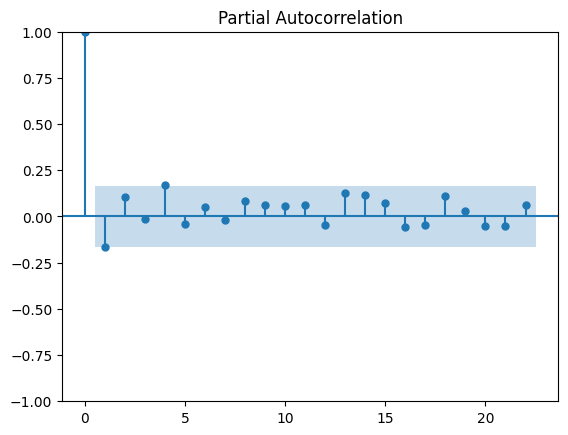

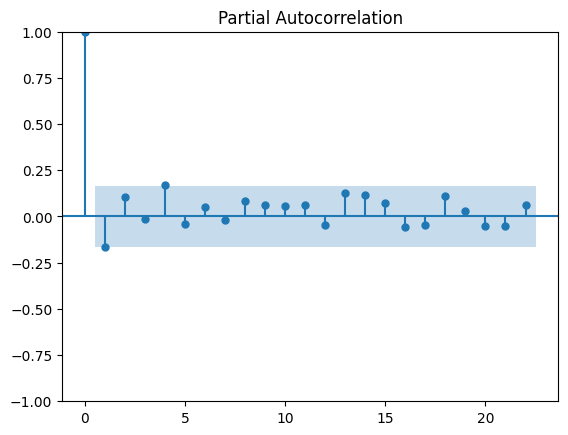

In [2183]:
plot_pacf(df_train['house_4'])

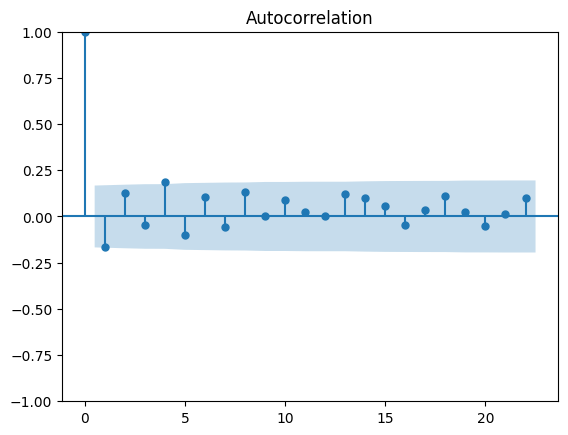

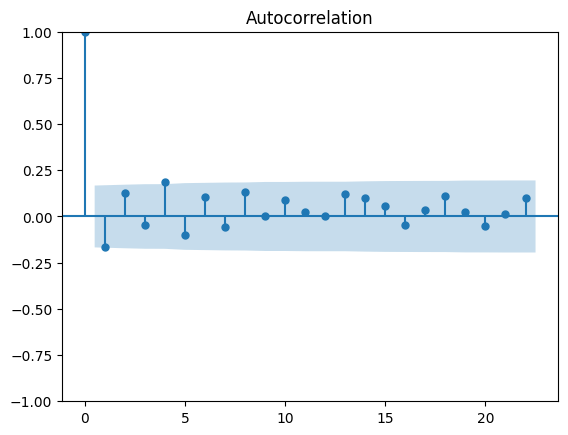

In [2184]:
plot_acf(df_train['house_4'])


In [2185]:
print(df_train)
model = VAR(df_train)
model_fit = model.fit(maxlags=6)
model_fit.summary()

index        house_4   house_3    unit_3    unit_2   house_5   house_1  \
2007-02-01  1.077919 -0.415985  0.362013 -0.091549  0.915737 -1.184482   
2007-03-01  0.381052 -0.897535  0.362013 -0.091549  0.915737 -1.184482   
2007-04-01  2.858735  0.083674  0.362013 -0.091549  0.915737 -1.184482   
2007-05-01  0.339627 -3.036059  0.362013 -0.091549  0.915737 -1.184482   
2007-06-01  1.643017 -0.081719  0.362013 -0.091549  0.915737 -1.184482   
...              ...       ...       ...       ...       ...       ...   
2018-02-01 -0.907777 -1.263674  1.264045 -0.806577  3.221895 -1.468780   
2018-03-01  1.173822  0.231073  0.345096  0.536353  1.512818 -2.998413   
2018-04-01  1.102821 -2.440740 -0.562004 -0.554794  3.172548 -1.184482   
2018-05-01  1.153851  0.021548  0.796973  0.632494  0.684417 -3.800171   
2018-06-01  0.339627  0.487757  0.362013 -0.091549  0.915737 -1.184482   

index        house_2    unit_1    unit_0    unit_4  
2007-02-01 -0.445622 -0.530188 -0.267734  0.683409  
2007-

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Jan, 2024
Time:                     00:35:28
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    8.89623
Nobs:                     131.000    HQIC:                  0.948185
Log likelihood:          -954.578    FPE:                  0.0243539
AIC:                     -4.49209    Det(Omega_mle):     0.000532437
--------------------------------------------------------------------
Results for equation house_4
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.317051         0.700863           -0.452           0.651
L1.house_4        -0.282653         0.126233           -2.239           0.025
L1.house_3        -0.182949         0.140827           -1.299         

In [2186]:
#get the predictions and residuals
predictions = model_fit.forecast(steps=df_test.shape[0], y=df_test.values)

predictions = pd.DataFrame(data=predictions, index=df_test.index, columns=df_test.columns.values)
df_residuals = df_test - predictions


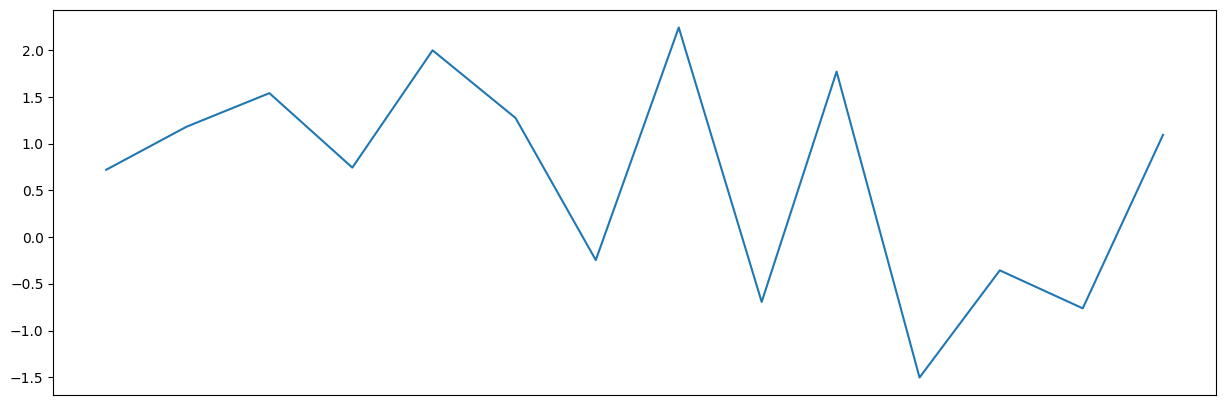

In [2187]:
compare_column = 'house_3'
my_plot(df_residuals, column=compare_column)

In [2188]:
df_data = pd.concat([df_train.tail(50), df_test], axis=0)

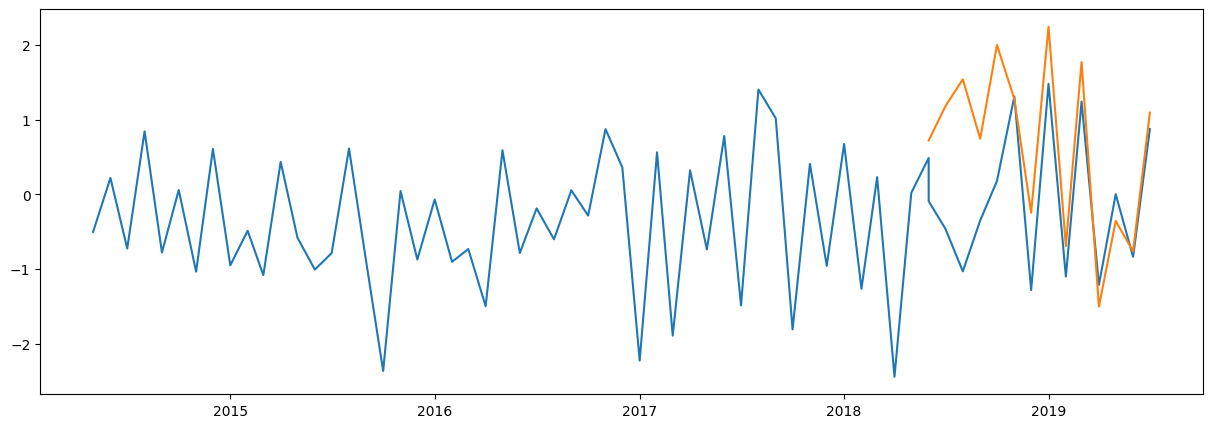

In [2189]:
plt.figure(figsize=(15,5))
plt.plot(df_data[compare_column])
plt.plot(df_residuals[compare_column])